<a href="https://colab.research.google.com/github/alexandraradivilko/BI_projects/blob/main/final_diary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание
- Постройте не менее двух моделей для предсказания с помощью ансамблевых методов. Какие модели были использованы в качестве основы, как вы их объединяли?
- Какая модель лучше? Какую модель вы выберете в качестве итоговой и почему?
- Опишите, какие переменные оказались наиболее значимыми в итоговой модели. Как минимум для одной из самых значимых переменных исследуйте динамику изменения. Какие выводы можно сделать?
- Выберите 1-2 примера из данных. Почему вы выбрали именно эти примеры? Интерпретируйте модель для этих примеров, сделайте выводы (SHAP или LIME)


### Источник данных СПБ ГБУЗ ГССМП, вызовы скорой мед. помощи на общественные места (не на дом) с полседующей госпиталиpацией за 2023 год
#### Основная задача: предсказание района, куда должна направиться бригада и ее требуемый профиль
Также стоит небольшая задача проверить предположение, основанное на субъективном ощущении, что на юге города инфарктов больше, чем на севере. То же можно сделать и с другими диагнозами.

#### Колонки
In['HOSPITAL_REQUEST', 'DIAGNOSIS', 'AGE', 'GENDER', 'CALL_DISTRICT',
       'CALL_LAT', 'CALL_LONG', 'HOSPITAL', 'PROFILE', 'HOSP_DISTRICT',
       'HOSP_LAT', 'HOSP_LONG', 'GSSMP_STATION', 'GSSMP_CALL_CREATED',
       'REASON', 'GSSMP_ARRIVED', 'GSSMP_TO_HOSPITAL', 'WAITING_MINUTES',
       'TIME_TO_HOSPITAL_M', 'dgroup', 'code', 'north']

- время запроса стационара бригадой
- диагноз
- возраст пациента
- пол пациента (0 - м, 1 - ж)
- район вызова
- широта адреса вызова
- долгота адреса вызова
- стационар
- профиль перевоза
- район стационара
- широта стационара
- долгота стационара
- подстанция ГССМП, откуда выехала бригада
- время создания карточки вызова
- причина вызова СМП
- время прибытия бригады к больному
- время прибытия в больницу
- время ожидания приезда СМП пациентом
- время в пути до стационара
- группа диагноза
- код диагноза
- относится район вызова СМП к северу (1) или к югу (0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import eli5
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv("/content/gsmp_df_clean.csv")
df.drop(df.columns[[0,1,3,19,20]], axis=1 , inplace=True)
df = df[df['TIME_TO_HOSPITAL_M']<300]
df[['HOSPITAL_REQUEST', 'GSSMP_CALL_CREATED','GSSMP_ARRIVED', 'GSSMP_TO_HOSPITAL']] = df[['HOSPITAL_REQUEST', 'GSSMP_CALL_CREATED','GSSMP_ARRIVED', 'GSSMP_TO_HOSPITAL']].apply(pd.to_datetime)
# удалим строки с пропущенными значениями
df = df.dropna()
# оставляем наблюдения с определенным районом юг/север df=df[df['north']!='other']
# оставляем только первые 5 групп диагнозов
top_values = df['dgroup'].value_counts().index[:5]

# Оставьте только записи, где 'dgroup' принимает одно из топ-5 значений
df = df[df['dgroup'].isin(top_values)]


In [ ]:
def get_time_of_day(hour):
    if 0 <= hour < 4:
        return 'night1'
    elif 4 <= hour < 8:
        return 'morning1'
    elif 8 <= hour < 12:
        return 'morning2'
    elif 12 <= hour < 16:
        return 'afternoon1'
    elif 16 <= hour < 20:
        return 'evening1'
    elif 20 <= hour < 24:
        return 'night2'

# Применение функции к столбцу времени
df['TIME_OF_DAY'] = df['GSSMP_CALL_CREATED'].dt.hour.apply(get_time_of_day)

# Задача
Предсказание района, из которого поступил вызов скорой помощи (CALL_DISTRICT).

### Входные признаки:

Время суток (TIME_OF_DAY): Утро, день, вечер или ночь.
Возраст пациента (AGE): Возраст пациента, которому была оказана помощь.
Пол пациента (GENDER): Пол пациента, который нуждался в помощи.
Время ожидания приезда СМП (WAITING_MINUTES): Время ожидания прибытия скорой помощи.
Время в пути до больницы (TIME_TO_HOSPITAL_M): Время, которое бригада скорой помощи затратила на дорогу до больницы.

In [ ]:
# оставляем только нужные столбцы
df = df[['TIME_OF_DAY', 'AGE', 'GENDER', 'WAITING_MINUTES', 'TIME_TO_HOSPITAL_M', 'CALL_DISTRICT']]
# удалю районы с 1-2 вызовами
district_counts = df['CALL_DISTRICT'].value_counts()
valid_districts = district_counts[district_counts > 2].index
df= df[df['CALL_DISTRICT'].isin(valid_districts)]


In [ ]:
df = pd.get_dummies(df, columns=['TIME_OF_DAY'], drop_first=True)
df['GENDER'] = df['GENDER'].astype(bool)

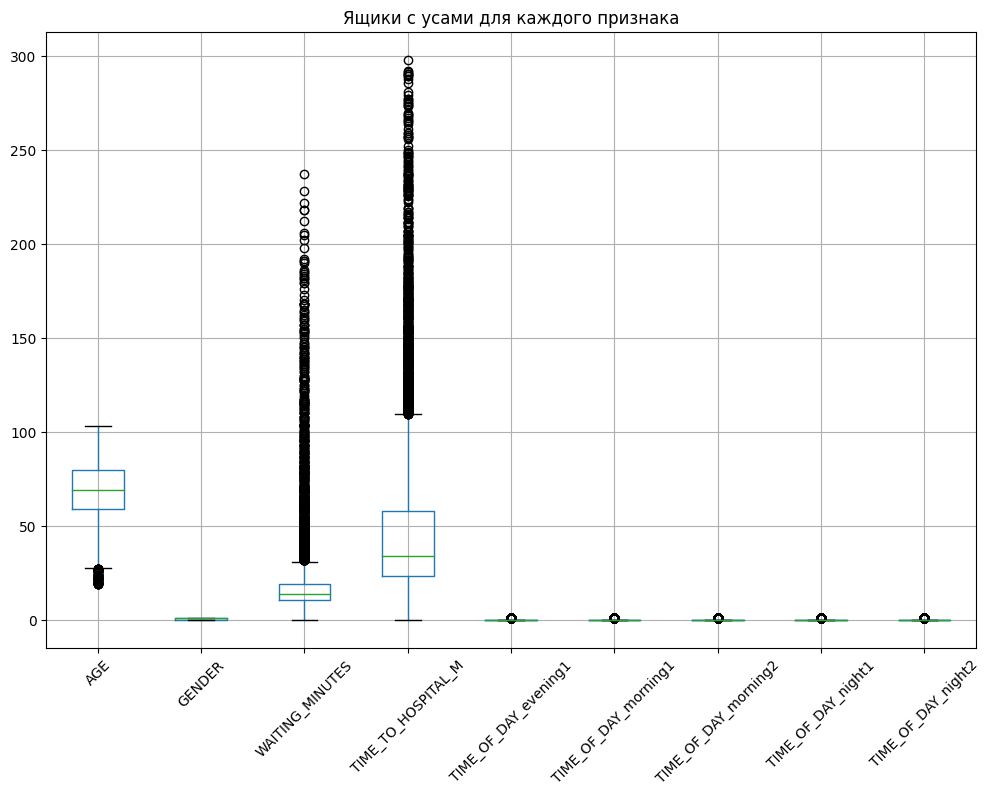

In [ ]:
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title('Ящики с усами для каждого признака')
plt.xticks(rotation=45)
plt.show()

## Ансамблевые модели
1. **Случайный лес (Random Forest, rf)**.
2. **Градиентный бустинг (Gradient Boosting, gb)**.
3. **Bagging**.
4. **AdaBoost**.


1. **Случайный лес (Random Forest)**: В случайном лесе используется агрегирование нескольких деревьев решений. Каждое дерево обучается независимо на случайной подвыборке данных, а затем результаты агрегируются для принятия решения.

2. **Градиентный бустинг (Gradient Boosting)**: Градиентный бустинг также использует ансамбль деревьев решений, но каждое последующее дерево настраивается на остатки предыдущей модели. Результаты всех деревьев суммируются, чтобы получить финальный результат.

3. **Bagging**: Bagging (Bootstrap Aggregating) создает несколько базовых моделей (в моем случае - деревьев решений) на случайных подмножествах обучающих данных с повторениями. Предсказания каждой модели затем усредняются для получения финального предсказания.

4. **AdaBoost (Adaptive Boosting)**: В AdaBoost базовые модели (например, деревья решений) обучаются итеративно, сосредотачиваясь на объектах, которые были неправильно классифицированы на предыдущих итерациях. Каждая последующая модель фокусируется на ошибках предыдущей модели, чтобы улучшить результат.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Разделим данные на признаки (X) и целевую переменную (y)
X = df.drop('CALL_DISTRICT', axis=1)
y = df['CALL_DISTRICT']

# Разделите данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Модель случайного леса
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=4)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Случайный лес - точность:", rf_accuracy)

# Модель градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=4)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Градиентный бустинг - точность:", gb_accuracy)


Случайный лес - точность: 0.152
Градиентный бустинг - точность: 0.1616


In [ ]:
print(rf_model.score(X_train, y_train), rf_model.score(X_test, y_test))
print(gb_model.score(X_train, y_train), gb_model.score(X_test, y_test))

0.16115261472785486 0.152
0.3363127001067236 0.1616


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Создаем базовую модель - деревья решений
base_model = DecisionTreeClassifier(max_depth=2)

bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
predictions = bagging_model.predict(X_test)

# точность модели
print(bagging_model.score(X_train, y_train), bagging_model.score(X_test, y_test))

0.1554162219850587 0.15146666666666667


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Создаем базовую модель - деревья решений
base_model = DecisionTreeClassifier(max_depth=1)

adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)

predictions = adaboost_model.predict(X_test)

#  точность модели
print(adaboost_model.score(X_train, y_train), adaboost_model.score(X_test, y_test))

0.1731590181430096 0.15626666666666666


### Вывод
- Случайный лес:

Точность на обучающем наборе: 0.161

Точность на тестовом наборе: 0.152
- Градиентный бустинг:

Точность на обучающем наборе: 0.336

Точность на тестовом наборе: 0.1616
- Bagging:

Точность на обучающем наборе: 0.1554

Точность на тестовом наборе: 0.1515
- AdaBoost:

Точность на обучающем наборе: 0.1732

Точность на тестовом наборе: 0.1563

Нилучшую производительность на тестовом наборе демонстрирует модель градиентного бустинга (gb), но и самое высокое значение точности на обучающем наборе, что может указывать на переобучение. Остановлюсь на модели AdaBoost, так как она имеет следующую по качеству точность и не имеет признаков переобучения.



# Исследование предикторов, больше всего влияющих на модель

In [ ]:
# Использование eli5 для выявления важности признаков
feature_names = X_train.columns.tolist()

In [ ]:
eli5.show_weights(adaboost_model, feature_names=feature_names)

Weight,Feature
0.5000 ± 1.0000,TIME_TO_HOSPITAL_M
0.2400 ± 0.8542,WAITING_MINUTES
0.1600 ± 0.7332,AGE
0.0200 ± 0.2800,TIME_OF_DAY_night2
0.0200 ± 0.2800,TIME_OF_DAY_morning2
0.0200 ± 0.2800,TIME_OF_DAY_morning1
0.0200 ± 0.2800,TIME_OF_DAY_evening1
0.0200 ± 0.2800,GENDER
0 ± 0.0000,TIME_OF_DAY_night1


### Вывод:
- TIME_TO_HOSPITAL_M: Этот признак имеет наибольший вес, что означает, что время до прибытия в больницу является наиболее важным для модели AdaBoost при принятии решений. Однако вес признака может варьироваться в диапазоне от -0.5 до 1.5, что указывает на некоторую неопределенность в значимости этого признака.
- WAITING_MINUTES: Этот признак имеет второй по величине вес, что означает, что время ожидания также оказывает значительное влияние на прогнозы модели, тоже имеет очень большой разброс.
- AGE: Возраст имеет небольшой вес, но все еще оказывает некоторое влияние на прогнозы модели, также наблюдается сильный рарброс и неопределенность.
- TIME_OF_DAY_night2, TIME_OF_DAY_morning2,   TIME_OF_DAY_morning1, TIME_OF_DAY_evening1, GENDER, TIME_OF_DAY_night1: эти признаки оказывают меньшее влияние на прогнозы модели.

Можно сделать вывод о высокой изменчивости количественных признаков в наших данных.

# Исследование поведения важных предикторов (PDP)
## Время до больницы

In [ ]:
df.CALL_DISTRICT.value_counts()

Выборгский           1357
Калининский           980
Приморский            827
Красногвардейский     792
Невский               781
Московский            738
Центральный           735
Красносельский        706
Фрунзенский           595
Кировский             565
Адмиралтейский        535
Василеостровский      444
Петроградский         316
Name: CALL_DISTRICT, dtype: int64

In [ ]:
# Возьмем только 1% наблюдений из X_train
half_X_train = X_train.sample(frac=0.1, random_state=42)


In [ ]:
from pycebox.ice import ice, ice_plot
def predict_new(X):
    return adaboost_model.predict_proba(X)[:,0]

time = ice(data=half_X_train, column='TIME_TO_HOSPITAL_M',
                   predict=predict_new)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


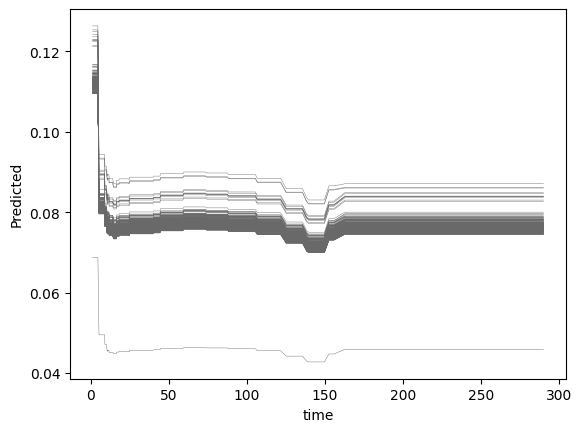

In [ ]:
# Предсказание для Выборгского района
ice_plot(time, c='dimgray', linewidth=0.3)
plt.ylabel('Predicted')
plt.xlabel('time');

Предсказание для Выборгского района выше для меньшего времени, потом наблюдается резкое снижение вероятности примерно до 8% для остального времени.

In [ ]:
from pycebox.ice import ice, ice_plot
def predict_new(X):
    return adaboost_model.predict_proba(X)[:,1]

time = ice(data=half_X_train, column='TIME_TO_HOSPITAL_M',
                   predict=predict_new)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


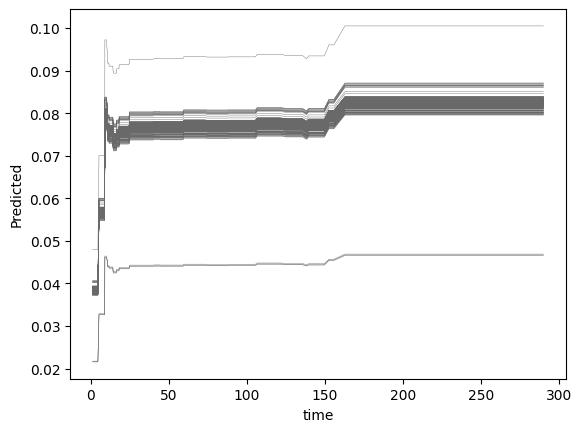

In [ ]:
# Предсказание для Калининского района
ice_plot(time, c='dimgray', linewidth=0.3)
plt.ylabel('Predicted')
plt.xlabel('time');

Предсказания для Калиниского района, наоборот, ниже для меньшего времени, примерно с 30 и до конца находится около 8%.

In [ ]:
from pycebox.ice import ice, ice_plot
def predict_new(X):
    return adaboost_model.predict_proba(X)[:,12]

time = ice(data=half_X_train, column='TIME_TO_HOSPITAL_M',
                   predict=predict_new)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


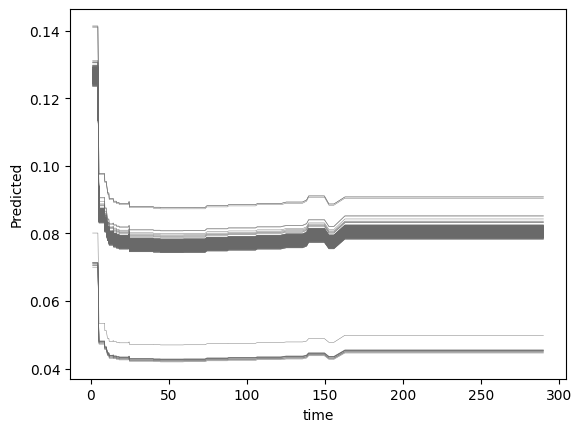

In [ ]:
# Предсказание для Петроградского района
ice_plot(time, c='dimgray', linewidth=0.3)
plt.ylabel('Predicted')
plt.xlabel('time');

Предсказание для Петроградского района (имеющего наименьшее кол-во наблюдений) выше для меньшего времени, основные предсказания держатся на том же уровне 8%, но присутствует так же и нкоторая часть наблдений в районе 4%.

# Вывод
Поведение предиктора времени для трех районов следующее:
1. Для Выборгского района предсказания модели начинаются с высокой вероятности для меньшего времени, затем происходит резкое снижение вероятности примерно до 8% для остального времени. Это указывает на то, что модель повысит вероятность этого района в предсказании, если значения врмени не большие.

2. Для Калининского района наблюдается обратная ситуация: предсказания модели начинаются с более низкой вероятности для меньшего времени, около 30%, и остаются на этом уровне примерно до конца временного интервала, приблизительно 8%. То есть меньшее время в водных данных понизит вероятность отнесния модели к классу Калиниского района.

3. Для Петроградского района, который имеет наименьшее количество наблюдений, предсказания модели также начинаются с высокой вероятности для меньшего времени. Основные предсказания держатся на уровне около 8%, однако также присутствует часть наблюдений в районе 4%. Тут ситуация схожа со вторым пунктом.

В целом, модель держит предсказанные вероятности около 8%.

# Объяснение примера с наибольшей и наименьшей ошибкой согласно исходной модели (LIME или SHAP).
Пример с наибольшей ошибкой может лучше других выражать модель, так как он представляет случай, когда модель сильно ошиблась в предсказании. Анализируя этот пример, можно выявить особенности или аномалии в данных, которые могут быть вызваны, например, выбросами.

Пример с наименьшей ошибкой, напротив, представляет случай, когда модель справилась с предсказанием данных очень точно. Изучая этот пример, можно выделить ключевые признаки или закономерности, которые модель успешно учла при прогнозировании.



In [ ]:
# библиотека от авторов метода
import lime
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
df.GENDER= df['GENDER'].astype('int')


In [ ]:
# Проведем некоторые преобразования, связанные с форматом данных для возможности исследовать с помощью LIME метода
df.GENDER= df['GENDER'].astype('int')
X1 = df.drop('CALL_DISTRICT', axis=1)
y1 = df['CALL_DISTRICT']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=5)
X_train1=X_train1.to_numpy()
X_test1= X_test1.to_numpy()

In [ ]:
# Построим ту же модель
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model1 = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)
adaboost_model.fit(X_train1, y_train1)
predictions = adaboost_model.predict(X_test1)

In [ ]:
# Выбираем пример с наибольшей ошибкой
errors = y_train != adaboost_model.predict(X_train)
index_max_error = np.argmax(errors)
instance_max_error = X_train.iloc[index_max_error]

# Выбираем пример с наименьшей ошибкой
index_min_error = np.argmin(errors)
instance_min_error = X_train.iloc[index_min_error]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [ ]:
print(instance_max_error)
print(y_train.iloc[index_max_error])

AGE                          70.0
GENDER                      False
WAITING_MINUTES              34.0
TIME_TO_HOSPITAL_M      97.833333
TIME_OF_DAY_evening1            0
TIME_OF_DAY_morning1            0
TIME_OF_DAY_morning2            0
TIME_OF_DAY_night1              0
TIME_OF_DAY_night2              0
Name: 10877, dtype: object
Василеостровский


In [ ]:
print(instance_min_error)
print(y_train.iloc[index_min_error])

AGE                      34.0
GENDER                  False
WAITING_MINUTES          33.0
TIME_TO_HOSPITAL_M      15.15
TIME_OF_DAY_evening1        0
TIME_OF_DAY_morning1        0
TIME_OF_DAY_morning2        0
TIME_OF_DAY_night1          0
TIME_OF_DAY_night2          0
Name: 2758, dtype: object
Выборгский


In [ ]:
# Предсказанный район : оба Выборгские
print(adaboost_model.predict(np.array(X_train.iloc[index_max_error]).reshape(1, -1)))
print(adaboost_model.predict(np.array(X_train.iloc[index_min_error]).reshape(1, -1)))

['Выборгский']
['Выборгский']


In [ ]:
# Предсказанный район : оба Выборгские
print(adaboost_model.predict_proba(np.array(X_train.iloc[index_max_error]).reshape(1, -1)))
print(adaboost_model.predict_proba(np.array(X_train.iloc[index_min_error]).reshape(1, -1)))

[[0.07763751 0.07679339 0.07903736 0.07681693 0.07597802 0.07716593
  0.07830982 0.07685982 0.07457909 0.07782331 0.07642742 0.07668028
  0.07589113]]
[[0.07617499 0.07209763 0.08020103 0.07717574 0.07601599 0.07653305
  0.07718256 0.07808422 0.0769726  0.07577404 0.07790028 0.07765309
  0.07823479]]


In [ ]:
proba = adaboost_model.predict_proba(np.array(X_train.iloc[index_max_error]).reshape(1, -1))[0]
classes = adaboost_model.classes_

for class_name, class_proba in zip(classes, proba):
    print(f"Вероятность класса {class_name}: {class_proba}")

Вероятность класса Адмиралтейский: 0.0776375080620069
Вероятность класса Василеостровский: 0.07679338726208192
Вероятность класса Выборгский: 0.07903736363550427
Вероятность класса Калининский: 0.07681692694084206
Вероятность класса Кировский: 0.07597801964492393
Вероятность класса Красногвардейский: 0.07716593084426764
Вероятность класса Красносельский: 0.07830981564266186
Вероятность класса Московский: 0.07685982296890256
Вероятность класса Невский: 0.07457908509066262
Вероятность класса Петроградский: 0.07782331289163966
Вероятность класса Приморский: 0.07642742129991076
Вероятность класса Фрунзенский: 0.07668027651619877
Вероятность класса Центральный: 0.07589112920039716


In [ ]:
explainer = LimeTabularExplainer(X_train1, mode='classification',feature_names=feature_names)

In [ ]:
exp1 = explainer.explain_instance(instance_max_error,
                                 adaboost_model.predict_proba,  top_labels=2)

In [ ]:
exp1.show_in_notebook()

In [ ]:
proba = adaboost_model.predict_proba(np.array(X_train.iloc[index_max_error]).reshape(1, -1))[0]
classes = adaboost_model.classes_

class_probabilities = sorted(zip(classes, proba), key=lambda x: x[1], reverse=True)

print('Предсказания для примера с максимальной ошибкой:')

for class_name, class_proba in class_probabilities:
    print(f"Вероятность класса {class_name}: {class_proba:.3f}")

Предсказания для примера с максимальной ошибкой:
Вероятность класса Выборгский: 0.079
Вероятность класса Красносельский: 0.078
Вероятность класса Петроградский: 0.078
Вероятность класса Адмиралтейский: 0.078
Вероятность класса Красногвардейский: 0.077
Вероятность класса Московский: 0.077
Вероятность класса Калининский: 0.077
Вероятность класса Василеостровский: 0.077
Вероятность класса Фрунзенский: 0.077
Вероятность класса Приморский: 0.076
Вероятность класса Кировский: 0.076
Вероятность класса Центральный: 0.076
Вероятность класса Невский: 0.075


### Пример с наибольшей ошибкой
- Время до больницы здесь больше других повлияло на решение, что это Выборгский район;
- Время ожидания немного перетягивает в сторону того, что это не выборский район;
- В целом, все значения очень малы, играют небольшую роль в решении, распределение вероятностей по другим районам примерно одинакове.

Для примера с максимальной ошибкой вероятности классов достаточно близки друг к другу и колеблются в диапазоне от 0.079 до 0.076. Это может указывать на то, что модель имеет затруднения в точном определении правильного класса для данного примера.

In [ ]:
exp2 = explainer.explain_instance(instance_min_error,
                                 adaboost_model.predict_proba, top_labels=2)

In [ ]:
exp2.show_in_notebook()

In [ ]:
proba = adaboost_model.predict_proba(np.array(X_train.iloc[index_min_error]).reshape(1, -1))[0]
classes = adaboost_model.classes_

class_probabilities = sorted(zip(classes, proba), key=lambda x: x[1], reverse=True)

print('Предсказания для примера с минимальной ошибкой:')

for class_name, class_proba in class_probabilities:
    print(f"Вероятность класса {class_name}: {class_proba:.3f}")

Предсказания для примера с минимальной ошибкой:
Вероятность класса Выборгский: 0.080
Вероятность класса Центральный: 0.078
Вероятность класса Московский: 0.078
Вероятность класса Приморский: 0.078
Вероятность класса Фрунзенский: 0.078
Вероятность класса Красносельский: 0.077
Вероятность класса Калининский: 0.077
Вероятность класса Невский: 0.077
Вероятность класса Красногвардейский: 0.077
Вероятность класса Адмиралтейский: 0.076
Вероятность класса Кировский: 0.076
Вероятность класса Петроградский: 0.076
Вероятность класса Василеостровский: 0.072


### Пример с наименьшей ошибкой
- Опять же коэфициенты очень малы, скорее всего почти не решают;
- В этом примере время до больницы, возраст и время ожидания машины играют большую роль в классфикации, остальные признаки меньше.

Для примера с минимальной ошибкой вероятности классов также близки, но вероятность класса "Выборгский" немного выше остальных (0.080), что может указывать на более уверенное предсказание модели для этого примера.

# Вывод

В целом, разница в вероятностях между классами не очень большая, что может говорить о том, что модель имеет определенные трудности в точном разграничении классов на основе предоставленных данных.
